# Image Super-Resolution with CNN

We will be using the DIV2K dataset to train the model. We split the 2k resolution images into patches of 17×17 to provide as model input for training. 

In [ ]:
# !apt update && apt install -y libsm6 libxext6 libxrender-dev
# !apt install -y libgl1-mesa-glx
# %pip install opencv-python
# %pip install tensorflow-macos --upgrade
# %pip install tensorflow-macos --upgrade
# %pip install matplotlib
# %conda install -c apple tensorflow-deps
# %pip install tensorflow_addons
# !pip install wandba

In [1]:
import os
import math
import cv2
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Conv2DTranspose, concatenate, PReLU, UpSampling2D, Add, BatchNormalization

from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
upscale_factor = 2
learning_rate = 4*1e-04
epochs = 50
input_shape = (None, None, 3)
batch_size = 128
weight_decay = 4*1e-05

In [3]:
# k_f = [96, 76, 65, 55, 47, 39, 32]
k_f = [32, 26, 22, 18, 14, 11, 8]

In [4]:
def feature_net(inputs, **conv_args):
    x1 = Conv2D(k_f[0], 3, **conv_args)
    x1 = tfa.layers.WeightNormalization(x1)(inputs)
    x1 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x1)


    x2 = Conv2D(k_f[1], 3, **conv_args)
    x2 = tfa.layers.WeightNormalization(x2)(x1)
    x2 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x2)

    
    x3 = Conv2D(k_f[2], 3, **conv_args)
    x3 = tfa.layers.WeightNormalization(x3)(x2)
    x3 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x3)

    
    x4 = Conv2D(k_f[3], 3, **conv_args)
    x4 = tfa.layers.WeightNormalization(x4)(x3)
    x4 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x4)


    x5 = Conv2D(k_f[4], 3, **conv_args)
    x5 = tfa.layers.WeightNormalization(x5)(x4)
    x5 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x5)


    x6 = Conv2D(k_f[5], 3, **conv_args)
    x6 = tfa.layers.WeightNormalization(x6)(x5)
    x6 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x6)


    x7 = Conv2D(k_f[6], 3,**conv_args)
    x7 = tfa.layers.WeightNormalization(x7)(x6)
    x7 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(x7)

    concat1 = concatenate([x1, x2, x3, x4, x5, x6, x7])

    return concat1

In [ ]:
def feature_net(inputs, **conv_args):
    x1 = Conv2D(32, 3, kernel_regularizer=regularizers.l2(0.0001), name='fen-conv1-3x3', **conv_args)(inputs)
    x1 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2], name='prelu1-conv1')(x1)
    Dropout(0.8)
    x2 = Conv2D(26, 3, kernel_regularizer=regularizers.l2(0.0001), name='fen-conv2-3x3', **conv_args)(x1)
    x2 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2],  name='prelu2-conv2')(x2)
    Dropout(0.8)
    x3 = Conv2D(22, 3, kernel_regularizer=regularizers.l2(0.0001), name='fen-conv3-3x3', **conv_args)(x2)
    x3 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2],  name='prelu3-conv3')(x3)
    Dropout(0.8)
    x4 = Conv2D(18, 3,kernel_regularizer=regularizers.l2(0.0001), name='fen-conv4-3x3', **conv_args)(x3)
    x4 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2],  name='prelu4-conv4')(x4)
    Dropout(0.8)
    x5 = Conv2D(14, 3,  kernel_regularizer=regularizers.l2(0.0001), name='fen-conv5-3x3', **conv_args)(x4)
    x5 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2],  name='prelu5-conv5')(x5)
    Dropout(0.8)
    x6 = Conv2D(11, 3, kernel_regularizer=regularizers.l2(0.0001), name='fen-conv6-3x3', **conv_args)(x5)
    x6 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2],  name='prelu6-conv6')(x6)
    Dropout(0.8)
    x7 = Conv2D(8, 3,  kernel_regularizer=regularizers.l2(0.0001), name='fen-conv7-3x3', **conv_args)(x6)
    # x7 = BatchNormalization()(x7)
    x7 = PReLU(alpha_initializer=Constant(value=0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2], name='prelu7-conv7')(x7)
    Dropout(0.8)
    concat1 = concatenate([x1, x2, x3, x4, x5, x6, x7])
    return concat1

In [ ]:
def reconstruction(concat1, **conv_args):
    a = Conv2D(64, 1,  **conv_args)
    a = tfa.layers.WeightNormalization(a)(concat1)
    a = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(a)
    
    b = Conv2D(32, 1, **conv_args)
    b = tfa.layers.WeightNormalization(b)(concat1)
    b = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(b)
    

    b2 = Conv2D(32, 3, **conv_args)
    b2 = tfa.layers.WeightNormalization(b2)(b)
    b2 = PReLU(alpha_initializer=tf.initializers.constant(0.25), alpha_regularizer=None, alpha_constraint=None, shared_axes=[1, 2])(b2)
    # Dropout(0.8)
    concat2 = concatenate([a, b2])
    return concat2

In [ ]:
def get_model(upscale_factor=upscale_factor, channels=1):

    conv_args = {
        "use_bias":"True",
        "kernel_initializer": "uniform",
        "bias_initializer":"zeros",
        "padding": "same",
    }
    inputs = Input(shape=(None, None, channels))
    # print(inputs)

    # bicubic_interp = cv2.resize(inputs, (0, 0), method='bicubic')
    bicubic_upsamp = UpSampling2D(size=(1, 1), data_format=None, interpolation='bilinear')(inputs)
    bicubic_upsamp = Conv2D(channels, 1, padding='same')(bicubic_upsamp)
    bicubic_upsamp = PReLU(alpha_initializer=tf.initializers.constant(0.25), name='bicubic_upsamp', alpha_regularizer=None, 
                           alpha_constraint=None, shared_axes=[1, 2])(bicubic_upsamp)
    # bicubic_upsamp = Conv2DTranspose(1, 3, strides=(1, 1), **conv_args)(inputs)
    # bicubic_upsamp = tf.image.resize(inputs, (1, 1), method='bicubic')
    
    # feature network
    fn = feature_net(inputs, **conv_args)
    
    # reconstruction network
    rec_n = reconstruction(fn, **conv_args)
    
    # L last layer 
    l = Conv2D(channels * (upscale_factor ** 2), 1)(rec_n)
    l = Add()([l, bicubic_upsamp])
    PS = Conv2D(channels * (upscale_factor ** 2), 1, **conv_args)(l)
    out = tf.nn.depth_to_space(PS, upscale_factor, data_format='NHWC')
    # out = SubpixelConv2D(upsampling_factor=upscale_factor)(PS)
    # out = Add()([PS, bicubic_upsamp])
    outputs = Conv2D(channels, 1, padding='same')(out)
    # print(outputs.shape)
    # outputs = Add()([outputs, bicubic_upsamp])
    # last = Add()([l, bicubic_interp])
    # outputs = tf.nn.depth_to_space(last, upscale_factor)
    
    return tf.keras.Model(inputs, outputs)

In [ ]:
def gen_dataset(filenames, scale):
    # The model trains on 17x17 patches
    crop_size_LowR = 48
    crop_size_hr = 48 * scale

    for p in filenames:
        
        image_decoded = cv2.imread("data/DIV2K_train_HR/"+p.decode(), 3).astype(np.float32) / 255.0
        imgYCC = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2YCrCb)
        Intr_cropped = imgYCC[0:(imgYCC.shape[0] - (imgYCC.shape[0] % scale)),
                  0:(imgYCC.shape[1] - (imgYCC.shape[1] % scale)), :]
        LowR = cv2.resize(Intr_cropped, (int(Intr_cropped.shape[1] / scale), int(Intr_cropped.shape[0] / scale)),
                        interpolation = cv2.INTER_NEAREST)
                        # interpolation=cv2.INTER_CUBIC)

        HighR_y = imgYCC[:, :, 0]
        LowR_x = LowR[:, :, 0]

        numx = int(LowR.shape[0] / crop_size_LowR)
        numy = int(LowR.shape[1] / crop_size_LowR)
        for i in range(0, numx):
            startx = i * crop_size_LowR
            endx = (i * crop_size_LowR) + crop_size_LowR
            startx_hr = i * crop_size_hr
            endx_hr = (i * crop_size_hr) + crop_size_hr
            for j in range(0, numy):
                starty = j * crop_size_LowR
                endy = (j * crop_size_LowR) + crop_size_LowR
                starty_hr = j * crop_size_hr
                endy_hr = (j * crop_size_hr) + crop_size_hr

                crop_LowR = LowR_x[startx:endx, starty:endy]
                crop_hr = HighR_y[startx_hr:endx_hr, starty_hr:endy_hr]

                hr = crop_hr.reshape((crop_size_hr, crop_size_hr, 1))
                LowR = crop_LowR.reshape((crop_size_LowR, crop_size_LowR, 1))
                yield LowR, hr

In [ ]:
def get_val_dataset(filenames, scale):
    # The model trains on 17x17 patches
    crop_size_LowR = 48
    crop_size_hr = 48 * scale

    for p in filenames:
        
        image_decoded = cv2.imread("data/DIV2K_valid_HR/"+p.decode(), 3).astype(np.float32) / 255.0
        imgYCC = cv2.cvtColor(image_decoded, cv2.COLOR_BGR2YCrCb)
        Intr_cropped = imgYCC[0:(imgYCC.shape[0] - (imgYCC.shape[0] % scale)),
                  0:(imgYCC.shape[1] - (imgYCC.shape[1] % scale)), :]
        LowR = cv2.resize(Intr_cropped, (int(Intr_cropped.shape[1] / scale), int(Intr_cropped.shape[0] / scale)),
                        interpolation = cv2.INTER_NEAREST)
                        # interpolation=cv2.INTER_CUBIC)

        HighR_y = imgYCC[:, :, 0]
        LowR_x = LowR[:, :, 0]

        numx = int(LowR.shape[0] / crop_size_LowR)
        numy = int(LowR.shape[1] / crop_size_LowR)
        for i in range(0, numx):
            startx = i * crop_size_LowR
            endx = (i * crop_size_LowR) + crop_size_LowR
            startx_hr = i * crop_size_hr
            endx_hr = (i * crop_size_hr) + crop_size_hr
            for j in range(0, numy):
                starty = j * crop_size_LowR
                endy = (j * crop_size_LowR) + crop_size_LowR
                starty_hr = j * crop_size_hr
                endy_hr = (j * crop_size_hr) + crop_size_hr

                crop_LowR = LowR_x[startx:endx, starty:endy]
                crop_hr = HighR_y[startx_hr:endx_hr, starty_hr:endy_hr]

                hr = crop_hr.reshape((crop_size_hr, crop_size_hr, 1))
                LowR = crop_LowR.reshape((crop_size_LowR, crop_size_LowR, 1))
                yield LowR, hr

In [ ]:
filenames = os.listdir("data/DIV2K_train_HR/")
valid_file = os.listdir("data/DIV2K_valid_HR/")

ds = tf.data.Dataset.from_generator(
        get_get_training_dataset, (tf.float32, tf.float32), 
        (tf.TensorShape([None, None, 1]), 
        tf.TensorShape([None, None, 1])),
        args=[filenames, upscale_factor]).batch(batch_size).shuffle(buffer_size=32)

val_ds = tf.data.Dataset.from_generator(
        val_get_get_training_dataset, (tf.float32, tf.float32), 
        (tf.TensorShape([None, None, 1]), 
        tf.TensorShape([None, None, 1])),
        args=[valid_file, upscale_factor]).batch(batch_size)

In [7]:
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [5]:
# Loss functtion
def ssim_loss_metric(y_true, y_pred):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))

In [ ]:
# callback start here!
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)
early_reducing_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=0.5,
                              patience=5, min_LowR=0.000004)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [early_stopping_callback, early_reducing_callback, model_checkpoint_callback]

# opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# model.compile(optimizer=opt,
#               loss=charbonnier_loss, 
#               metrics=[PSNR])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 fen-conv1-3x3 (Conv2D)         (None, None, None,   320         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 prelu1-conv1 (PReLU)           (None, None, None,   32          ['fen-conv1-3x3[0][0]']          
                                32)                                                           

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="super-resolution", entity="mithunparab")

wandb.config = {
  "learning_rate": learning_rate,
  "epochs": epochs,
  "batch_size": batch_size,
  "weight_decay": weight_decay
}
callbacks = [early_stopping_callback, early_reducing_callback, model_checkpoint_callback, WandbCallback()]

opt = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
model.compile(optimizer=opt,
              loss=charbonnier_loss, 
              metrics=[PSNR])

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [ ]:
model.fit(ds,epochs=epochs,  validation_data=val_ds, callbacks=callbacks, shuffle=True, verbose=1) 

Epoch 1/100


2022-03-06 03:48:58.055942: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-06 03:48:58.059069: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-06 03:48:58.059206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-06 03:49:38.253584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


788/788 - 85s - loss: 0.0139 - PSNR: 24.3384 - val_loss: 0.0070 - val_PSNR: 23.6199
Epoch 2/100
788/788 - 44s - loss: 0.0042 - PSNR: 27.5531 - val_loss: 0.0242 - val_PSNR: 17.4713
Epoch 3/100
788/788 - 71s - loss: 0.0034 - PSNR: 28.3341 - val_loss: 0.0040 - val_PSNR: 26.1645
Epoch 4/100
788/788 - 44s - loss: 0.0030 - PSNR: 28.8369 - val_loss: 0.0069 - val_PSNR: 22.6789
Epoch 5/100
788/788 - 43s - loss: 0.0029 - PSNR: 28.6723 - val_loss: 0.0163 - val_PSNR: 18.3873
Epoch 6/100
788/788 - 65s - loss: 0.0029 - PSNR: 28.8831 - val_loss: 0.0049 - val_PSNR: 24.1169
Epoch 7/100
788/788 - 43s - loss: 0.0027 - PSNR: 29.3459 - val_loss: 0.0049 - val_PSNR: 24.0369
Epoch 8/100
788/788 - 66s - loss: 0.0026 - PSNR: 29.8446 - val_loss: 0.0041 - val_PSNR: 25.0688
Epoch 9/100
788/788 - 43s - loss: 0.0025 - PSNR: 30.0588 - val_loss: 0.0038 - val_PSNR: 25.8617
Epoch 10/100
788/788 - 71s - loss: 0.0025 - PSNR: 30.0856 - val_loss: 0.0028 - val_PSNR: 28.1994
Epoch 11/100
788/788 - 42s - loss: 0.0024 - PSNR: 3

Peak Signal to Noise Ratio is the most common technique used to determine the quality of results.

In [28]:
def PSNR(orig, reconstr):
    mse = np.mean((orig.astype(float) - reconstr.astype(float)) ** 2)
    if mse != 0:
        max_pixel = 255.0
        return 20 * math.log10(max_pixel / math.sqrt(mse))
    else:
        return 1


The authors convert RGB images to the YCrCb format, and then upscale the Y channel input using ESPCN. The Cr and Cb channels are upscaled using bicubic interpolation, and all the upscaled channels are stitched together to get the final HR image. Thus, while training, we only need to provide the Y channel of the low resolution data and the high resolution images to the model.

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow.keras.preprocessing.image import img_to_array
import PIL
    
def get_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0]// upscale_factor , img.size[1] // upscale_factor)
    )

def get_lowRes_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0], img.size[1]),
        PIL.Image.BICUBIC,
    )


def SR_upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    YCbCr = img.convert("YCbCr")
    y, cb, cr = YCbCr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]*4))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [ ]:
# fullimg = cv2.imread("data/test/157032.jpg", 3)

fullimg = cv2.imread("data/set5/img_002.png", -1)
# fullimg = cv2.imread("lastoutput/4-bicubic.png", 3)
width = int (fullimg.shape[0])
height = int (fullimg.shape[1])
crop_cut = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
# print(f"crop_cut: {crop_cut}")



floatimgCrop = crop_cut.astype(np.float32) /255
# print(f"FloatingCrop: {floatimgCrop}")
crop_cutYCbCr = cv2.cvtColor(floatimgCrop, cv2.COLOR_BGR2YCrCb)
CropimgY = crop_cutYCbCr[:, :, 0]

# img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation = cv2.INTER_NEAREST)
floatimg = img.astype(np.float32) /255
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
Y = model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)

HR_imageY = HR_image_YCrCb[:, :, 0]


bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
floatimgCubic = bicubic_image.astype(np.float32)/255
CubicYCbcr = cv2.cvtColor(floatimgCubic, cv2.COLOR_BGR2YCrCb)
CubicY = CubicYCbcr[:, :, 0]


print("PSNR of CNN generated image: ", PSNR(crop_cutYCbCr, HR_image_YCrCb))
# print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
print("PSNR of bicubic interpolated image: ", PSNR(crop_cutYCbCr, CubicYCbcr))

# crop_cut_gray = cv2.cvtColor(crop_cut, cv2.COLOR_BGR2GRAY)
# HR_image_GRAY = cv2.cvtColor(HR_image, cv2.COLOR_BGR2GRAY)
# bicubic_G = cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2GRAY)

print("SSIM of CNN generated image: ", tf.image.ssim(crop_cutYCbCr, HR_image_YCrCb, max_val=1).numpy())
# print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
print("SSIM of bicubic interpolated image: ", tf.image.ssim(crop_cutYCbCr, CubicYCbcr, max_val=1).numpy())

PSNR of CNN generated image:  38.878588461654736
PSNR of bicubic interpolated image:  34.29018001616433
SSIM of CNN generated image:  0.97617984
SSIM of bicubic interpolated image:  0.96040344


True

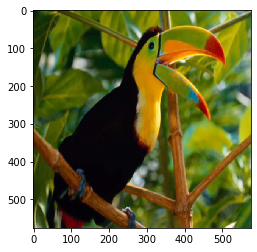

In [ ]:
predicted =cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB)
# predicted = cv2.resize(HR_image, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_NEAREST)
img = cv2.resize(crop_cut, None, fx=1, fy=1, interpolation=cv2.INTER_NEAREST)
# img = cv2.resize(crop_cut, None, fx=1, fy=1, interpolation = cv2.INTER_NEAREST)
floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
Y = model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                    axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)

plt.imshow(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB), interpolation="none")
cv2.imwrite('predicted.png', bicubic_image)
# cv2.imwrite('pic.png', img)

True

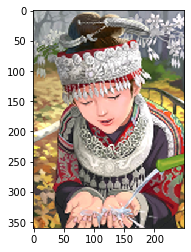

In [ ]:
bic1 = cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB)
bic =  cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB), interpolation="none")
cv2.imwrite('bic.png', bic)

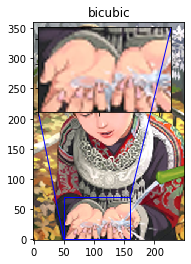

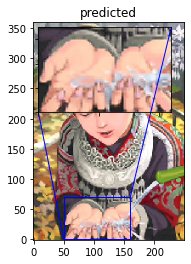

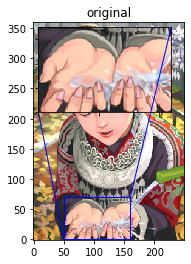

In [ ]:
get_plotted_results(bic1, '-', 'bicubic')
get_plotted_results(predicted, '-', 'predicted')
get_plotted_results(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), '-', 'original')

In [26]:
test_path = os.path.join("data", "set14")
test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".png")
    ]
)
print(test_img_paths)

['data/set14/img_001.png', 'data/set14/img_002.png', 'data/set14/img_003.png', 'data/set14/img_004.png', 'data/set14/img_005.png', 'data/set14/img_006.png', 'data/set14/img_007.png', 'data/set14/img_008.png', 'data/set14/img_009.png', 'data/set14/img_010.png', 'data/set14/img_011.png', 'data/set14/img_012.png', 'data/set14/img_013.png', 'data/set14/img_014.png']


data/set14/img_001.png
PSNR of Our generated image:  21.20565474150358
PSNR of bicubic interpolated image:  20.125322134614137
SSIM of CNN generated image:  0.60345495
SSIM of bicubic interpolated image:  0.54589504


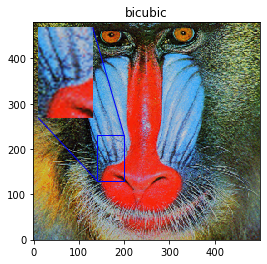

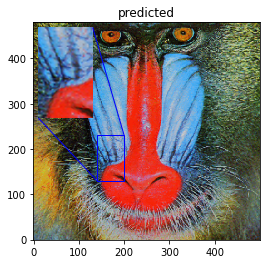

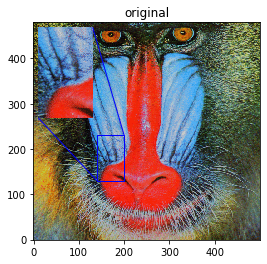

data/set14/img_002.png
PSNR of Our generated image:  25.19239369152458
PSNR of bicubic interpolated image:  23.714282755199303
SSIM of CNN generated image:  0.82484573
SSIM of bicubic interpolated image:  0.77010524


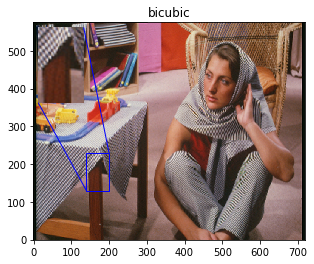

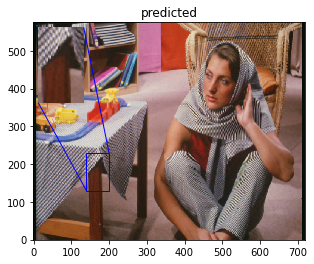

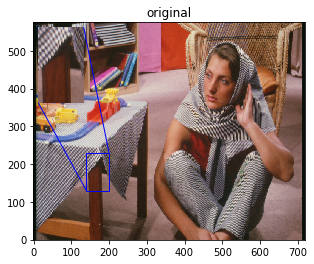

data/set14/img_003.png
PSNR of Our generated image:  25.93033914499696
PSNR of bicubic interpolated image:  23.848278209642118
SSIM of CNN generated image:  0.80110395
SSIM of bicubic interpolated image:  0.7160896


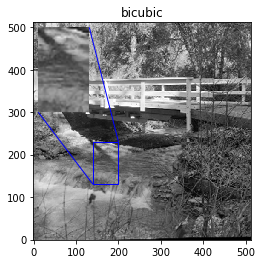

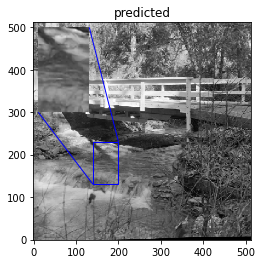

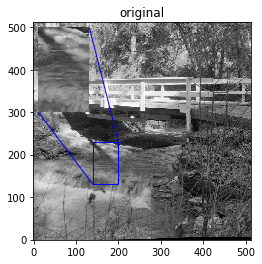

data/set14/img_004.png
PSNR of Our generated image:  28.32850273257098
PSNR of bicubic interpolated image:  25.492130724768117
SSIM of CNN generated image:  0.8061392
SSIM of bicubic interpolated image:  0.7093077


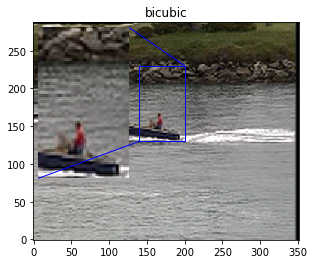

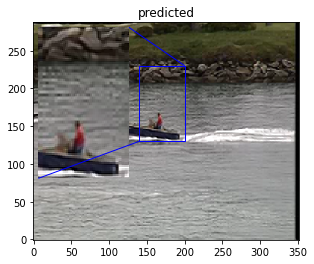

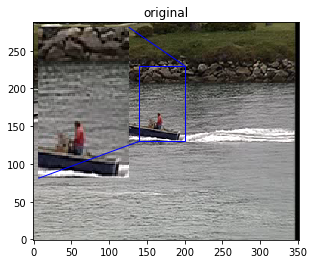

data/set14/img_005.png
PSNR of Our generated image:  24.92336624859494
PSNR of bicubic interpolated image:  21.962546623743275
SSIM of CNN generated image:  0.86410564
SSIM of bicubic interpolated image:  0.7799256


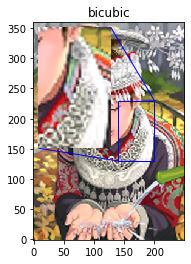

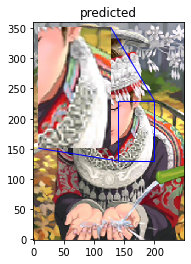

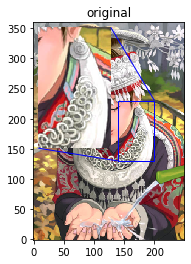

data/set14/img_006.png
PSNR of Our generated image:  30.135338629881836
PSNR of bicubic interpolated image:  28.7147403169759
SSIM of CNN generated image:  0.76755184
SSIM of bicubic interpolated image:  0.7226521


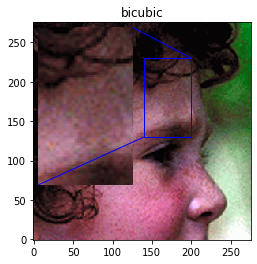

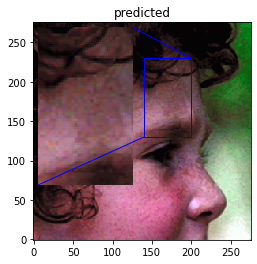

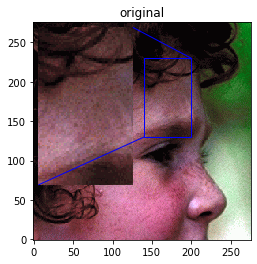

data/set14/img_007.png
PSNR of Our generated image:  28.140078374164826
PSNR of bicubic interpolated image:  25.518569582527544
SSIM of CNN generated image:  0.86260366
SSIM of bicubic interpolated image:  0.8262453


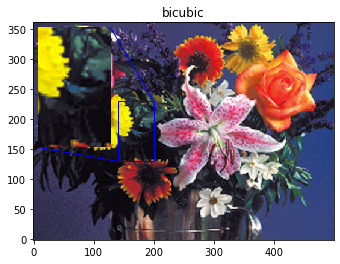

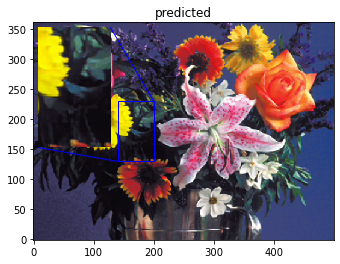

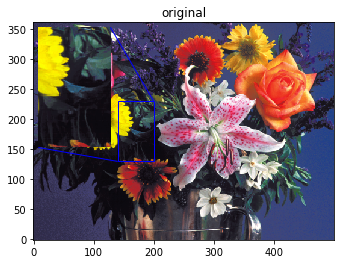

data/set14/img_008.png
PSNR of Our generated image:  30.26545493220288
PSNR of bicubic interpolated image:  27.82704031132248
SSIM of CNN generated image:  0.9501755
SSIM of bicubic interpolated image:  0.9157545


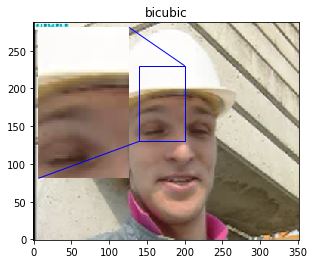

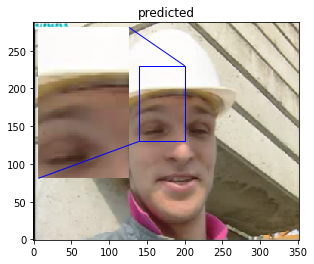

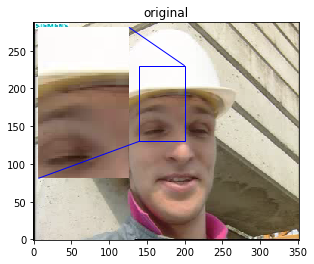

data/set14/img_009.png
PSNR of Our generated image:  31.534965273823744
PSNR of bicubic interpolated image:  28.938910574836125
SSIM of CNN generated image:  0.8211443
SSIM of bicubic interpolated image:  0.7826876


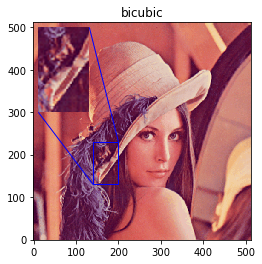

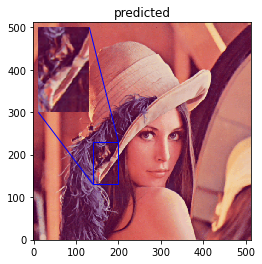

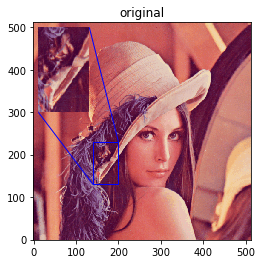

data/set14/img_010.png
PSNR of Our generated image:  27.73705328504789
PSNR of bicubic interpolated image:  25.12435594963482
SSIM of CNN generated image:  0.83476543
SSIM of bicubic interpolated image:  0.7590827


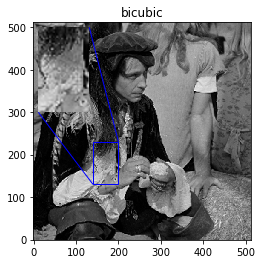

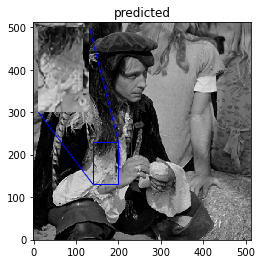

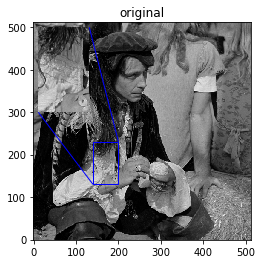

data/set14/img_011.png
PSNR of Our generated image:  32.962318344519936
PSNR of bicubic interpolated image:  28.31564922893419
SSIM of CNN generated image:  0.9566194
SSIM of bicubic interpolated image:  0.9229836


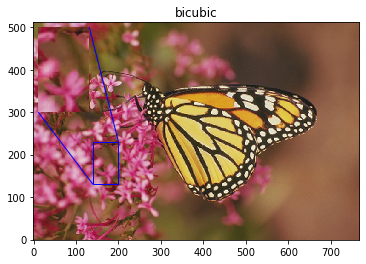

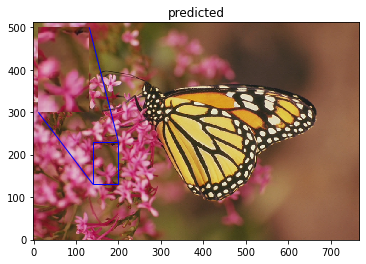

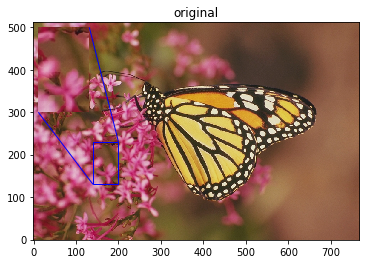

data/set14/img_012.png
PSNR of Our generated image:  28.930913397982202
PSNR of bicubic interpolated image:  27.347012893839278
SSIM of CNN generated image:  0.7872244
SSIM of bicubic interpolated image:  0.765784


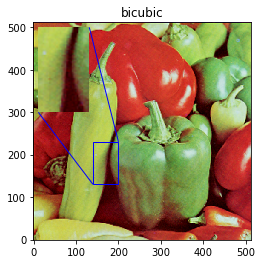

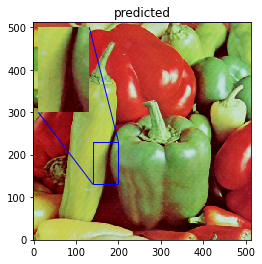

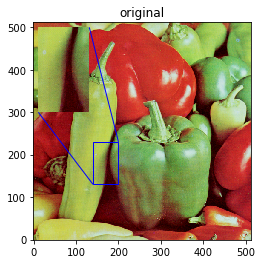

data/set14/img_013.png
PSNR of Our generated image:  25.78042152967193
PSNR of bicubic interpolated image:  22.35714776224622
SSIM of CNN generated image:  0.94569623
SSIM of bicubic interpolated image:  0.90317196


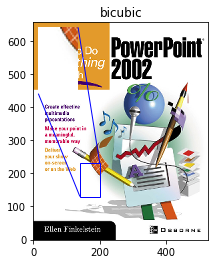

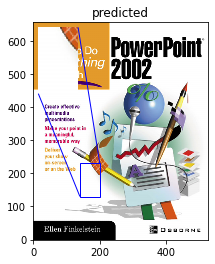

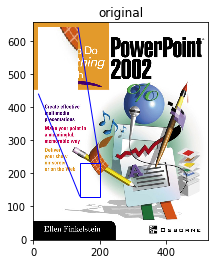

data/set14/img_014.png
PSNR of Our generated image:  30.2628314143154
PSNR of bicubic interpolated image:  25.077537963709467
SSIM of CNN generated image:  0.9122286
SSIM of bicubic interpolated image:  0.8387569


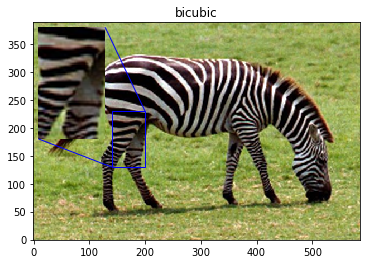

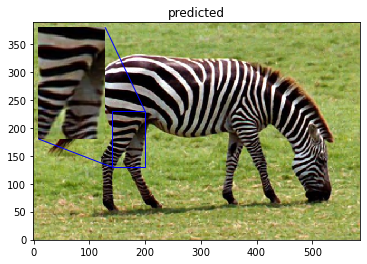

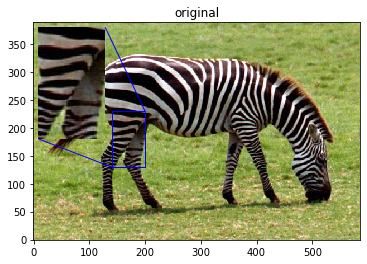

Avg. PSNR of lowres images is 25.3117
Avg. PSNR of reconstructions is 27.9521
Avg. SSIM of lowres images is 0.7827
Avg. SSIM of reconstructions is 0.8384


In [29]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

total_bicubic_ssim = 0.0
total_test_ssim = 0.0

for index, test_img_path in enumerate(test_img_paths):
    print(test_img_path)
    # fullimg = cv2.imread("data/test/157032.jpg", 3)
    fullimg = cv2.imread(test_img_path, 3)
    # fullimg = cv2.imread("tiger.png", 3)
    width = int (fullimg.shape[0])
    height = int (fullimg.shape[1])
    Intr_cropped = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
    # img = cv2.resize(Intr_cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(Intr_cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation = cv2.INTER_NEAREST)
    floatimg = img.astype(np.float32) / 255.0
    imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
    imgY = imgYCbCr[:, :, 0]
    LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
    Y = model.predict([LR_input_])[0]
    Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
    HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
    HR_image = (HR_image).astype(np.uint8)
    bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

    print("PSNR of Our generated image: ", PSNR(Intr_cropped, HR_image))
    # print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    
    Intr_cropped_gray = cv2.cvtColor(Intr_cropped, cv2.COLOR_BGR2GRAY)
    HR_image_GRAY = cv2.cvtColor(HR_image, cv2.COLOR_BGR2GRAY)
    bicubic_G = cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2GRAY)

    print("SSIM of CNN generated image: ", tf.image.ssim(Intr_cropped, HR_image, max_val=255).numpy())
    # print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    print("SSIM of bicubic interpolated image: ", tf.image.ssim(Intr_cropped, bicubic_image, max_val=255).numpy())
    
    total_bicubic_psnr += PSNR(Intr_cropped, bicubic_image)
    total_test_psnr += PSNR(Intr_cropped, HR_image)
    total_bicubic_ssim +=  tf.image.ssim(Intr_cropped, bicubic_image, max_val=255)
    total_test_ssim +=   tf.image.ssim(Intr_cropped, HR_image, max_val=255)
    
    get_ploted_results(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB), index, 'bicubic')
    get_ploted_results(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB), index, 'predicted')
    get_ploted_results(cv2.cvtColor(Intr_cropped, cv2.COLOR_BGR2RGB), index, 'original')
    

    
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 14))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 14))
print("Avg. SSIM of lowres images is %.4f" % (total_bicubic_ssim / 14))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 14))  

In [ ]:
def charbonnier_loss(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.square(y_true - y_pred) + tf.square(1e-3)))
model = tf.keras.models.load_model('supRes.h5', custom_objects={"PSNR": PSNR, "charbonnier_loss": charbonnier_loss})

# Check its architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 weight_normalization (WeightNo  (None, None, None,   673        ['input_1[0][0]']                
 rmalization)                   32)                                                               
                                                                                                  
 prelu1-conv1 (PReLU)           (None, None, None,   32          ['weight_normalization[0][0]']   
                                32)                                                           

In [25]:
test_path1 = os.path.join("data", "set5")
test_img_paths1 = sorted(
    [
        os.path.join(test_path1, fname)
        for fname in os.listdir(test_path1)
        if fname.endswith(".png")
    ]
)
print(test_img_paths1)

['data/set5/img_001.png', 'data/set5/img_002.png', 'data/set5/img_003.png', 'data/set5/img_004.png', 'data/set5/img_005.png']


In [24]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

total_bicubic_ssim = 0.0
total_test_ssim = 0.0

for index, test_img_path in enumerate(test_img_paths1):
    print(test_img_path)
    # fullimg = cv2.imread("data/test/157032.jpg", 3)
    fullimg = cv2.imread(test_img_path, 3)
    # fullimg = cv2.imread("tiger.png", 3)
    width = int (fullimg.shape[0])
    height = int (fullimg.shape[1])
    Intr_cropped = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
    # img = cv2.resize(Intr_cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(Intr_cropped, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation = cv2.INTER_NEAREST)
    floatimg = img.astype(np.float32) / 255.0
    imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
    imgY = imgYCbCr[:, :, 0]
    LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
    Y = model.predict([LR_input_])[0]
    Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
    HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
    HR_image = (HR_image).astype(np.uint8)
    bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)

    print("PSNR of Our generated image: ", PSNR(Intr_cropped, HR_image))
    # print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    
    Intr_cropped_gray = cv2.cvtColor(Intr_cropped, cv2.COLOR_BGR2GRAY)
    HR_image_GRAY = cv2.cvtColor(HR_image, cv2.COLOR_BGR2GRAY)
    bicubic_G = cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2GRAY)

    print("SSIM of CNN generated image: ", tf.image.ssim(Intr_cropped, HR_image, max_val=255).numpy())
    # print("PSNR of bicubic interpolated image: ", PSNR(Intr_cropped, bicubic_image))
    print("SSIM of bicubic interpolated image: ", tf.image.ssim(Intr_cropped, bicubic_image, max_val=255).numpy())
    
    total_bicubic_psnr += PSNR(Intr_cropped, bicubic_image)
    total_test_psnr += PSNR(Intr_cropped, HR_image)
    total_bicubic_ssim +=  tf.image.ssim(Intr_cropped, bicubic_image, max_val=255)
    total_test_ssim +=   tf.image.ssim(Intr_cropped, HR_image, max_val=255)
    
    get_ploted_results(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB), index, 'bicubic')
    get_ploted_results(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB), index, 'predicted')
    get_ploted_results(cv2.cvtColor(Intr_cropped, cv2.COLOR_BGR2RGB), index, 'original')
    

    
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 5))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 5))
print("Avg. SSIM of lowres images is %.4f" % (total_bicubic_ssim / 5))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 5))  

NameError: name 'test_img_paths1' is not defined

In [ ]:
test_path2 = os.path.join("data", "bsd100/")
test_img_paths2 = sorted(
    [
        os.path.join(test_path2, fname)
        for fname in os.listdir(test_path2)
        if fname.endswith(".png") and not fname.startswith('.')
    ]
)
print(test_img_paths2)

['data/bsd100/img_001.png', 'data/bsd100/img_002.png', 'data/bsd100/img_003.png', 'data/bsd100/img_004.png', 'data/bsd100/img_005.png', 'data/bsd100/img_006.png', 'data/bsd100/img_007.png', 'data/bsd100/img_008.png', 'data/bsd100/img_009.png', 'data/bsd100/img_010.png', 'data/bsd100/img_011.png', 'data/bsd100/img_012.png', 'data/bsd100/img_013.png', 'data/bsd100/img_014.png', 'data/bsd100/img_015.png', 'data/bsd100/img_016.png', 'data/bsd100/img_017.png', 'data/bsd100/img_018.png', 'data/bsd100/img_019.png', 'data/bsd100/img_020.png', 'data/bsd100/img_021.png', 'data/bsd100/img_022.png', 'data/bsd100/img_023.png', 'data/bsd100/img_024.png', 'data/bsd100/img_025.png', 'data/bsd100/img_026.png', 'data/bsd100/img_027.png', 'data/bsd100/img_028.png', 'data/bsd100/img_029.png', 'data/bsd100/img_030.png', 'data/bsd100/img_031.png', 'data/bsd100/img_032.png', 'data/bsd100/img_033.png', 'data/bsd100/img_034.png', 'data/bsd100/img_035.png', 'data/bsd100/img_036.png', 'data/bsd100/img_037.png', 

In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

total_bicubic_ssim = 0.0
total_test_ssim = 0.0

for index, test_img_path1 in enumerate(test_img_paths2):
    
    # fullimg = cv2.imread("data/test/157032.jpg", 3)
    fullimg = cv2.imread(test_img_path1, 3)
    # fullimg = cv2.imread("tiger.png", 3)
    width = int (fullimg.shape[0])
    height = int (fullimg.shape[1])
    crop_cut = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
    
    floatimgCrop = crop_cut.astype(np.float32) / 255.0
    crop_cutYCbCr = cv2.cvtColor(floatimgCrop, cv2.COLOR_BGR2YCrCb)
    CropimgY = crop_cutYCbCr[:, :, 0]
    # img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
    img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation = cv2.INTER_NEAREST)
    floatimg = img.astype(np.float32) / 255.0
    imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
    imgY = imgYCbCr[:, :, 0]
    LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
    Y = model.predict([LR_input_])[0]
    Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
    HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
    HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
    HR_image = (HR_image).astype(np.uint8)
    bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
    
    bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
    floatimgCubic = bicubic_image.astype(np.float32) / 255.0
    CubicYCbcr = cv2.cvtColor(floatimgCubic, cv2.COLOR_BGR2YCrCb)
    CubicY = CubicYCbcr[:, :, 0]

    print("PSNR of Our generated image: ", PSNR(crop_cutYCbCr, HR_image_YCrCb))
    # print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
    print("PSNR of bicubic interpolated image: ", PSNR(crop_cutYCbCr, CubicYCbcr))
    
    crop_cut_gray = cv2.cvtColor(crop_cut, cv2.COLOR_BGR2GRAY)
    HR_image_GRAY = cv2.cvtColor(HR_image, cv2.COLOR_BGR2GRAY)
    bicubic_G = cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2GRAY)

    print("SSIM of CNN generated image: ", tf.image.ssim(crop_cutYCbCr, HR_image_YCrCb, max_val=1).numpy())
    # print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
    print("SSIM of bicubic interpolated image: ", tf.image.ssim(crop_cutYCbCr, CubicYCbcr, max_val=1).numpy())
    
    total_test_psnr += PSNR(crop_cutYCbCr, HR_image_YCrCb)
    total_bicubic_psnr += PSNR(crop_cutYCbCr, CubicYCbcr)
    total_bicubic_ssim +=  tf.image.ssim(crop_cutYCbCr, CubicYCbcr, max_val=1).numpy()
    total_test_ssim +=   tf.image.ssim(crop_cutYCbCr, HR_image_YCrCb, max_val=1).numpy()
    
    get_plotted_results(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB), index, 'bicubic')
    get_plotted_results(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB), index, 'predicted')
    get_plotted_results(cv2.cvtColor(crop_cut, cv2.COLOR_BGR2RGB), index, 'original')
    

    
print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 100))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 100))
print("Avg. SSIM of lowres images is %.4f" % (total_bicubic_ssim / 100))
print("Avg. SSIM of reconstructions is %.4f" % (total_test_ssim / 100))  

PSNR of Our generated image:  28.866934198719314
PSNR of bicubic interpolated image:  26.7636288575505
SSIM of CNN generated image:  0.9055166
SSIM of bicubic interpolated image:  0.8714652
PSNR of Our generated image:  33.98693591624162
PSNR of bicubic interpolated image:  30.699008487119215
SSIM of CNN generated image:  0.9596509
SSIM of bicubic interpolated image:  0.93897164
PSNR of Our generated image:  31.293172499497608
PSNR of bicubic interpolated image:  29.00534285663996
SSIM of CNN generated image:  0.95452183
SSIM of bicubic interpolated image:  0.9326719
PSNR of Our generated image:  37.19539399473496
PSNR of bicubic interpolated image:  33.79300775578181
SSIM of CNN generated image:  0.9769664
SSIM of bicubic interpolated image:  0.95842826
PSNR of Our generated image:  31.985098159802252
PSNR of bicubic interpolated image:  29.557114734862488
SSIM of CNN generated image:  0.9445526
SSIM of bicubic interpolated image:  0.91914463
PSNR of Our generated image:  39.646184139

In [20]:
def get_ploted_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower", interpolation="none")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower", interpolation="none")


    # Specify the limits.
    # x1, x2, y1, y2 = 50, 160, 0, 70
    x1, x2, y1, y2 = 140, 200, 130, 230
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.axis("off")
    # plt.savefig("outputs/"+str(prefix) + "-" + title + ".png")
    plt.show()

PSNR of Our generated image:  38.43370226950966
PSNR of bicubic interpolated image:  34.29018001616433
SSIM of CNN generated image:  0.97530127
SSIM of bicubic interpolated image:  0.96040344


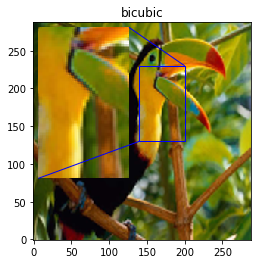

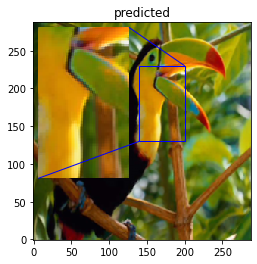

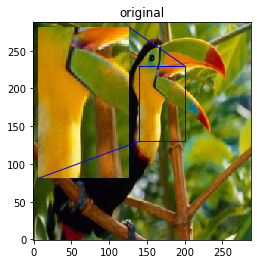

In [23]:
fullimg = cv2.imread("data/set5/img_002.png", 3)
# fullimg = cv2.imread("tiger.png", 3)
width = int (fullimg.shape[0])
height = int (fullimg.shape[1])
crop_cut = fullimg[0:(width - (width % upscale_factor)), 0:(height - (height % upscale_factor)), :]
 
floatimgCrop = crop_cut.astype(np.float32) / 255.0
crop_cutYCbCr = cv2.cvtColor(floatimgCrop, cv2.COLOR_BGR2YCrCb)
CropimgY = crop_cutYCbCr[:, :, 0]
# img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation=cv2.INTER_CUBIC)
img = cv2.resize(crop_cut, None, fx=1. / upscale_factor, fy=1. / upscale_factor, interpolation = cv2.INTER_NEAREST)
floatimg = img.astype(np.float32) / 255.0
imgYCbCr = cv2.cvtColor(floatimg, cv2.COLOR_BGR2YCrCb)
imgY = imgYCbCr[:, :, 0]
LR_input_ = imgY.reshape(1, imgY.shape[0], imgY.shape[1], 1)
Y = model.predict([LR_input_])[0]
Cr = np.expand_dims(cv2.resize(imgYCbCr[:, :, 1], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
Cb = np.expand_dims(cv2.resize(imgYCbCr[:, :, 2], None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC),
                        axis=2)
HR_image_YCrCb = np.concatenate((Y, Cr, Cb), axis=2)
HR_image = ((cv2.cvtColor(HR_image_YCrCb, cv2.COLOR_YCrCb2BGR)) * 255.0).clip(min=0, max=255)
HR_image = (HR_image).astype(np.uint8)
bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
    
bicubic_image = cv2.resize(img, None, fx=upscale_factor, fy=upscale_factor, interpolation=cv2.INTER_CUBIC)
floatimgCubic = bicubic_image.astype(np.float32) / 255.0
CubicYCbcr = cv2.cvtColor(floatimgCubic, cv2.COLOR_BGR2YCrCb)
CubicY = CubicYCbcr[:, :, 0]

print("PSNR of Our generated image: ", PSNR(crop_cutYCbCr, HR_image_YCrCb))
# print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
print("PSNR of bicubic interpolated image: ", PSNR(crop_cutYCbCr, CubicYCbcr))

print("SSIM of CNN generated image: ", tf.image.ssim(crop_cutYCbCr, HR_image_YCrCb, max_val=1).numpy())
# print("PSNR of bicubic interpolated image: ", PSNR(crop_cut, bicubic_image))
print("SSIM of bicubic interpolated image: ", tf.image.ssim(crop_cutYCbCr, CubicYCbcr, max_val=1).numpy())

get_ploted_results(cv2.cvtColor(bicubic_image, cv2.COLOR_BGR2RGB), 0, 'bicubic')
get_ploted_results(cv2.cvtColor(HR_image, cv2.COLOR_BGR2RGB), 0, 'predicted')
get_ploted_results(cv2.cvtColor(crop_cut, cv2.COLOR_BGR2RGB), 0, 'original')


In [10]:
model = tf.keras.models.load_model('supRes.h5', custom_objects={"PSNR": PSNR, "charbonnier_loss": charbonnier_loss})

# Check its architecture
model.summary()

Metal device set to: Apple M1


2022-06-20 04:56:17.775112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-20 04:56:17.775250: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 weight_normalization (WeightNo  (None, None, None,   673        ['input_1[0][0]']                
 rmalization)                   32)                                                               
                                                                                                  
 p_re_lu (PReLU)                (None, None, None,   32          ['weight_normalization[0][0]']   
                                32)                                                           